In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pathlib
from scipy.linalg import lstsq
from qutip import *

In [55]:
np.random.seed(2)

In [56]:
n_spins = 4 #Objetivo: 5 o 6
h=1

def ising_hamiltonian(n_spins,h):

  si = qeye(2)
  sx = sigmax()
  sy = sigmay()
  sz = sigmaz()

  sx_list = []
  sy_list = []
  sz_list = []

  for n in range(n_spins):
      op_list = []
      for m in range(n_spins):
          op_list.append(si)

      op_list[n] = sx
      sx_list.append(tensor(op_list))

      op_list[n] = sy
      sy_list.append(tensor(op_list))

      op_list[n] = sz
      sz_list.append(tensor(op_list))

  #Hamiltonian

  H = 0

  #Transverse field

  for n in range(n_spins):
    H += - h* sz_list[n]

  #Interaction terms

  # Random interaction matrix
  np.random.seed(2)
  J_ij = -np.random.uniform(0, 1, size=(n_spins, n_spins))
  J_ij = (J_ij + J_ij.T) / 2  # Ensure symmetric matrix

  for n in range(n_spins):
    for m in range(n+1,n_spins):
      H += J_ij[n,m]*sx_list[n]*sx_list[m]

  return H

Werner State


In [57]:
#Insert input

#Initialize reservoir with a random density matrix

'''
def initial_state(n_spins):
  init = basis(2,0)

  for i in range(1,n_spins):
    init = tensor(init,basis(2,0))

  return init*init.dag()
'''


def initial_state(n_spins): #Random initial state (always the same)

  iter = rand_dm(2, seed=3)

  for i in range(1,n_spins):

    iter = tensor(iter,rand_dm(2, seed=2))

  return iter


reservoir = initial_state(n_spins)

def input_state(par): #Werner state with parameter par in [0,1]

  ap = basis(2,0)
  bp = basis(2,1)

  a = tensor(ap,bp)
  b = tensor(bp,ap)
  psi = (b-a)/np.sqrt(2)
  psi_matrix = psi*psi.dag()

  id = tensor(qeye(2),qeye(2))

  input_state = par*psi_matrix + (1-par)/4 * id

  return input_state

def insert_input(input_state, reservoir): #Insert a two qubit entangled state into the reservoir (Werner)

  n_spins = len(reservoir.dims[0])
  reduced = reservoir.ptrace([i for i in range(2,n_spins)])

  return tensor(input_state,reduced)


In [58]:
initial_state(4)

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.12005364+5.51898483e-22j -0.03751771-8.00845615e-04j
  -0.03751771-8.00845615e-04j  0.01171924+5.00541198e-04j
  -0.03751771-8.00845615e-04j  0.01171924+5.00541198e-04j
   0.01171924+5.00541198e-04j -0.00365902-2.34598998e-04j
  -0.01164396+3.04660833e-02j  0.00384206-9.44321869e-03j
   0.00384206-9.44321869e-03j -0.00126367+2.92545130e-03j
   0.00384206-9.44321869e-03j -0.00126367+2.92545130e-03j
  -0.00126367+2.92545130e-03j  0.00041442-9.05797123e-04j]
 [-0.03751771+8.00845615e-04j  0.09791492+2.94096551e-19j
   0.01172992+1.30588873e-18j -0.03059919-6.53164149e-04j
   0.01172992+1.25167862e-18j -0.03059919-6.53164149e-04j
  -0.00366569-7.82471814e-05j  0.00955813+4.08237942e-04j
   0.0034356 -9.59856609e-03j -0.00949673+2.48479270e-02j
  -0.00113768+2.97671000e-03j  0.00313356-7.70182389e-03j
  -0.00113768+2.97671000e-03j  0.00313356-7.70182389e-03j
   0.0003753

In [59]:
input_state(0.5).full()

array([[ 0.125+0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
       [ 0.   +0.j,  0.375+0.j, -0.25 +0.j,  0.   +0.j],
       [ 0.   +0.j, -0.25 +0.j,  0.375+0.j,  0.   +0.j],
       [ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.125+0.j]])

In [60]:
#Measure z observable over all the qubits except the first two
#medimos con sz_list

def expectation_sxyz(rho): #measure sz exp value over all spins
  n_spins = len(rho.dims[0])

  si = qeye(2)
  sx = sigmax()
  sy = sigmay()
  sz = sigmaz()

  sx_list = []
  sy_list = []
  sz_list = []

  for n in range(n_spins):
      op_list = []
      for m in range(n_spins):
          op_list.append(si)

      op_list[n] = sx
      sx_list.append(tensor(op_list))

      op_list[n] = sy
      sy_list.append(tensor(op_list))

      op_list[n] = sz
      sz_list.append(tensor(op_list))

  exp = []
  for i in range(n_spins): #range(2,n_spins)
    exp.append(expect(rho,sx_list[i]))
    exp.append(expect(rho,sy_list[i]))
    exp.append(expect(rho,sz_list[i]))

  return exp

In [61]:
#Function with two qubit state as input and output of the evolved reservoir

def QRC(param,n_spins):

  h=-1
  H = ising_hamiltonian(n_spins,h)

  reservoir = initial_state(n_spins)
  input = input_state(param)
  reservoir_inserted = insert_input(input, reservoir)

  #Evolve state
  time = 5
  time_list = [i for i in range(time)]

  rho = mesolve(H, reservoir_inserted, time_list).states[-1]
  #exp = np.array(rho.expect)[-1]

  #Measure sx, sy, sz exp values
  #print(rho)
  exp = expectation_sxyz(rho)

  #Linear combination with optimization parameters
  return exp

In [62]:
QRC(0.5,4)

[0.0505683477834242,
 -0.022173841559450708,
 0.06839317356510297,
 0.030124132174615757,
 0.016733807945656112,
 0.08537957983092384,
 -0.01998851444820427,
 -0.03179995102481617,
 -0.021031852990772835,
 -0.022419202644628204,
 -0.0008287724749978303,
 0.04030898258102786]

In [63]:
#Training
total = 500
train_time = int(0.8*total)
test_time = total-train_time


#Generate random parameters lambda for the input state
params = [np.random.uniform(0,1) for _ in range(total)]
train = params[:train_time]
test = params[train_time:]


# Getting optimal weights
n_spins = 4

output = np.zeros([train_time, 3*n_spins+1])
for i in range(train_time):
  output[i,:] = (QRC(train[i],n_spins))+ [1]

opt_weights, _, _, _ = lstsq(output,train) # n_spins weights + 1 (término independiente)
train_predicted = np.matmul(output,opt_weights)

output_test = np.zeros([test_time, 3*n_spins+1])

for i in range(test_time):
  output_test[i,:] = (QRC(test[i],n_spins))+ [1]


In [64]:
predicted = np.matmul(output_test,opt_weights)

5.718799523475183e-19


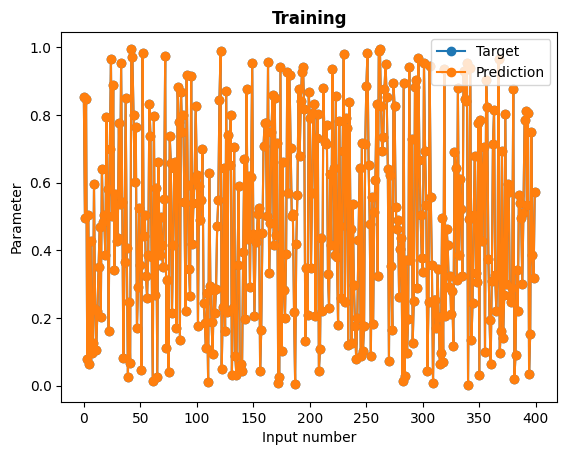

In [65]:
plt.title('Training', fontweight="bold")
plt.plot(np.arange(train_time), train, marker='o', label= 'Target')
plt.plot(np.arange(train_time), train_predicted, marker='o', label = 'Prediction')
plt.xlabel('Input number')
plt.ylabel('Parameter')
plt.legend()

mse_train = np.mean((train_predicted - train) ** 2)
print(mse_train)

4.938829717927221e-19


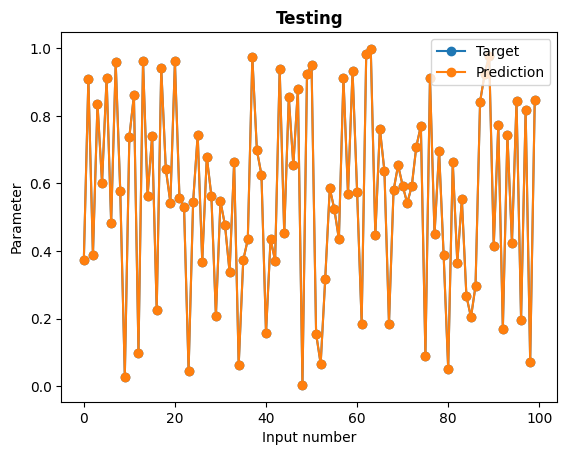

In [66]:
plt.title('Testing', fontweight="bold")
plt.plot(np.arange(test_time), test, marker='o', label = 'Target')
plt.plot(np.arange(test_time), predicted, marker='o', label = 'Prediction')
plt.xlabel('Input number')
plt.ylabel('Parameter')
plt.legend()

mse_test = np.mean((predicted - test) ** 2)
print(mse_test)

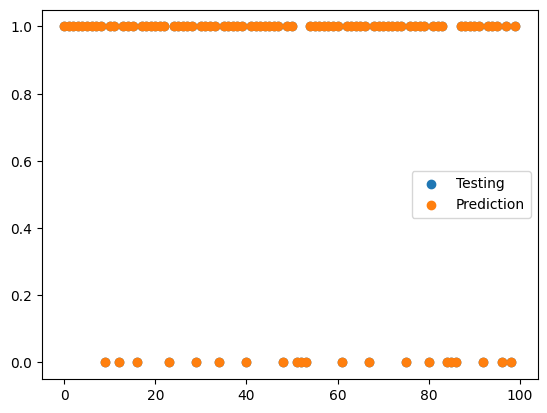

In [67]:
entanglement_test = np.zeros(len(predicted))
entanglement_prediction = np.zeros(len(predicted))
for i in range(len(predicted)):
  if predicted[i] <= 1/3:
    entanglement_prediction[i] = 0
  else:
    entanglement_prediction[i] = 1


for i in range(len(predicted)):
  if test[i] <= 1/3:
    entanglement_test[i] = 0 #not entangled
  else:
    entanglement_test[i] = 1 #Entangled

plt.scatter(np.arange(test_time), entanglement_test, label = 'Testing')
plt.scatter(np.arange(test_time), entanglement_prediction, label = 'Prediction')
plt.legend()

Text(0.5, 1.0, 'Prediction - test')

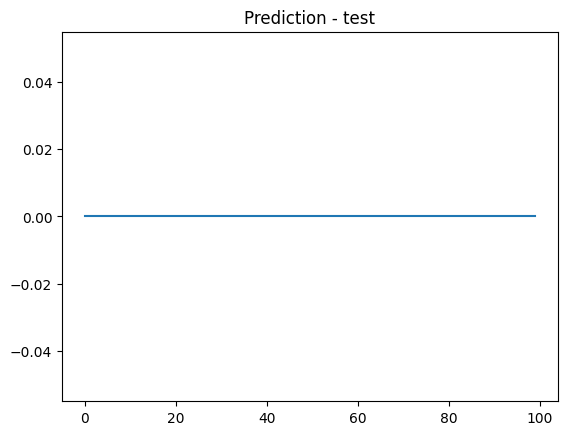

In [68]:
plt.plot(entanglement_prediction-entanglement_test)
plt.title('Prediction - test')

In [69]:
def input_state_cross(p,c1,c2):
     
  q = 1/2 - p
    
  if c1 > abs(p) or c2 > abs(q):
      raise Exception("Not physical")
      
  ap = basis(2,0)
  bp = basis(2,1)

  a1 = tensor(ap,bp)
  b1 = tensor(bp,ap)
  a2 = tensor(ap,ap)
  b2 = tensor(bp,bp)

  f1 = a1*a1.dag() + b1*b1.dag()
  f2 = a2*a2.dag() + b2*b2.dag()
  f3 = a2*b2.dag() + b2*a2.dag()
  f4 = a1*b1.dag() + b1*a1.dag()

  rho = p*f2+ q*f1+ c1*f3 + c2*f4

  return rho

In [70]:
#Function with two qubit state as imput and output of the evolved reservoir

def QRC(state,n_spins):

  h=-1
  H = ising_hamiltonian(n_spins,h)

  rho = initial_state(n_spins)

  for i in range(3):
      reservoir_inserted = insert_input(state, rho)
      
      #Evolve state
      time = 5
      time_list = [i for i in range(time)]

      rho = mesolve(H, reservoir_inserted, time_list).states[-1]
      

  #Measure sx, sy, sz exp values
  exp = expectation_sxyz(rho)

  #Linear combination with optimization parameters
  return exp

In [71]:
#Training
total = 200
train_time = int(0.8*total)
test_time = total-train_time

states = []
conc = []

for i in range(total):
    p = np.random.uniform(-2,2)
    q = 1/2 - p
    c1 = np.random.uniform(-abs(p), abs(p))
    c2 = np.random.uniform(-abs(q), abs(q))

    state = input_state_cross(p,c1,c2)
    states.append(state)
    conc.append(concurrence(state))

#Generate random states for the input state

train = states[:train_time]
conc_train = conc[:train_time]
test = states[train_time:]
conc_test = conc[train_time:]



# Getting optimal weights
n_spins = 6

output = np.zeros([train_time, 3*n_spins+1])
for i in range(train_time):
  output[i,:] = (QRC(train[i],n_spins))+ [1]

opt_weights, _, _, _ = lstsq(output,conc_train) # n_spins weights + 1 (término independiente)
train_predicted = np.matmul(output,opt_weights)

output_test = np.zeros([test_time, 3*n_spins+1])

for i in range(test_time):
  output_test[i,:] = (QRC(test[i],n_spins))+ [1]


predicted = np.matmul(output_test,opt_weights)


0.04196656187162186


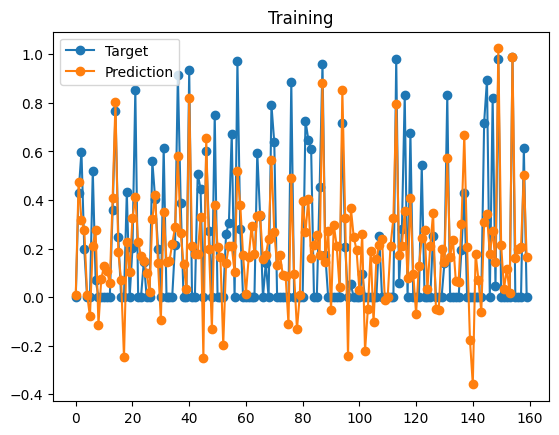

In [72]:
plt.title('Training')
plt.plot(np.arange(train_time), conc_train, marker='o', label= 'Target')
plt.plot(np.arange(train_time), train_predicted, marker='o', label = 'Prediction')
plt.legend()

mse_train = np.mean((train_predicted - conc_train) ** 2)
print(mse_train)

0.07500992870723915


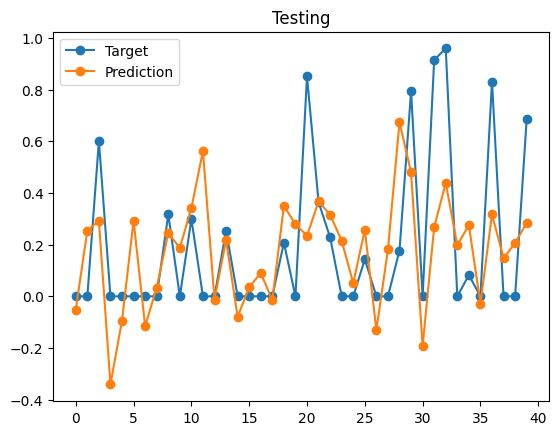

In [73]:
plt.title('Testing')
plt.plot(np.arange(test_time), conc_test, marker='o', label = 'Target')
plt.plot(np.arange(test_time), predicted, marker='o', label = 'Prediction')
plt.legend()

mse_test = np.mean((predicted - conc_test) ** 2)
print(mse_test)